# Table of contents

* [Number of finished cards per month](#finished-cards-bar)
* [Rolling number of finished cards in last 30 days](#finished-cards-rolling)
* [Finished feature cards per month](#finished-feature-cards-per-month)
* [Rolling view: Finished feature cards in the last 30 days](#finished-cards-rolling-features)
* [Number of regression bugs per month](#regression-bugs)
* [Current cards in development](#development-cards)
* [Changelog](#changelog)

# Date of last generation

In [1]:
import datetime

current_datetime = datetime.datetime.now()

print("Time of last creation of this analysis:", current_datetime)

Time of last creation of this analysis: 2023-12-09 20:09:38.099276


# Get API key and token for accessing the Trello API

Go to https://trello.com/power-ups/admin to access your token (see https://developer.atlassian.com/cloud/trello/guides/rest-api/authorization/ for documentation). Open https://trello.com/1/authorize?expiration=1day&name=MyPersonalToken&scope=read&response_type=token&key=YourAPIKey with replacing `YourAPIKey` with your personal key in order to generate your token.

In [24]:
import os

API_KEY = os.environ.get("TRELLO_API_KEY", None)
TOKEN = os.environ.get("TRELLO_TOKEN", None)

from getpass import getpass

if API_KEY is None:
    API_KEY = getpass("Trello API Key")

if TOKEN is None:
    TOKEN = getpass("Trello Token")

Trello API Key ········
Trello Token ········


# Download all cards

In [3]:
import requests
import json

BOARD_ID = 'pfDnwT4D'

def api_call(endpoint, additional_params):
    params = {
        'key': API_KEY,
        'token': TOKEN,
        'limit': 1000,
    }
    params.update(additional_params)
    
    response = requests.get(
            f"https://api.trello.com/1{endpoint}",
            headers={ "Accept": "application/json" },
            params=params
    )

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code {response.status_code}")
            
def get_cards(board_id):
    return api_call(f"/boards/{board_id}/cards", { 'filter': 'all' })
        
cards = get_cards(BOARD_ID)

print(f"Downloaded cards: {len(cards)}")

Downloaded cards: 413


In [34]:
def get_actions(card_id):
    return api_call(f"/cards/{card_id}/actions", { "filter": "updateCard:idList,copyCard,createCard,convertToCardFromCheckItem", })

for card in cards:
    card["actions"] = list(reversed(get_actions(card["id"])))

In [35]:
def get_attachments(card_id):
    return api_call(f"/cards/{card_id}/attachments", {})

for card in cards:
    card["attachments"] = get_attachments(card["id"])

In [5]:
def get_lists(board_id):
    return api_call(f"/boards/{board_id}/lists", {})

lists = get_lists(BOARD_ID)
list_id2list_name = dict((l["id"], l["name"]) for l in lists)
list_name2list_id = dict((l["name"], l["id"]) for l in lists)

# Validation of the data

In [6]:
def is_move_action(action):
    return "listBefore" in action["data"] and "listAfter" in action["data"]

for card in cards:
    card["actions"] = [action for (index, action) in enumerate(card["actions"]) if (action["type"] != "updateCard" and index == 0) or is_move_action(action)]
    
def is_valid_card(card):
    return len(card["actions"]) > 0 and is_first_action_copy_or_create(card) and is_tail_of_actions_move_actions(card)

def is_first_action_copy_or_create(card):
    return card["actions"][0]["type"] in ["createCard", "copyCard", "convertToCardFromCheckItem"]

def is_tail_of_actions_move_actions(card):
    return all(is_move_action(action) for action in card["actions"][1:])

valid_cards = [card for card in cards if is_valid_card(card)]
invalid_cards = [card for card in cards if not is_valid_card(card)]

print(f"Invalid cards: {len(invalid_cards)}")

for card in invalid_cards:
    print(card["name"])
    prettyprint(card["actions"])

Invalid cards: 0


# Helper function for displaying cards

In [7]:
import pandas as pd

from datetime import timezone, datetime

def get_time_in_lists(card):
    result = dict((l["id"], pd.Timedelta(0)) for l in lists)
    
    if card["idList"] not in result:
        result[card["idList"]] = pd.Timedelta(0)
    
    last_time = pd.to_datetime(card["actions"][0]["date"]) 
    
    for action in card["actions"][1:]:
        diff = pd.to_datetime(action["date"]) - last_time
        
        if action["data"]["listBefore"]["id"] in result:
            result[action["data"]["listBefore"]["id"]] += diff
        
        last_time = pd.to_datetime(action["date"])
    
    result[card["idList"]] += pd.to_datetime(datetime.now(timezone.utc))-last_time
    
    return result

get_time_in_lists(cards[200])

{'63bc34d346143f025ffe3152': Timedelta('7 days 19:24:33.407000'),
 '6374b6c8d908a5001de2fa7b': Timedelta('73 days 16:30:25.079000'),
 '6374b6c8d908a5001de2fa7c': Timedelta('5 days 17:38:44.957257'),
 '6374b70b76ae9a0265bb679b': Timedelta('0 days 00:00:00'),
 '6374b723ad21d7062366f9b6': Timedelta('0 days 00:00:00'),
 '641838c6ee62b9f7a7fa8ac2': Timedelta('0 days 00:00:00'),
 '6374b72bcbb33c0681d4b99b': Timedelta('0 days 00:00:00')}

In [8]:
def get_last_move_date(card):
    dates = [a["date"] for a in card["actions"] if is_move_action(a) or a["type"] in ["createCard", "copyCard"]]
             
    return max(dates)

get_last_move_date(cards[200])

'2023-12-04T01:33:46.121Z'

In [9]:
from IPython.display import display, HTML, Markdown

def print_card(card, display_time=True, display_last_move_date=True):
    html = '<div style="padding: 1em; border: 3px black solid; border-radius: 1em; background: #f2f2f2">'
    
    if len(card["labels"]) > 0:
        html += '<div>'
        for label in card["labels"]:
            html += f'<span style="display: inline-block; border: 1px black solid; padding: 0.25em; border-radius: 0.125em; margin-right: 1em; background: #e0e0e0">{label["name"]}</span>'
        html += '</div>'
    
    if display_last_move_date:
        last_move_date = pd.to_datetime(get_last_move_date(card)).strftime('%d.%m.%Y')
        last_move_date = f" ({last_move_date})"
    else:
        last_move_date = ""
    
    html += f'<h3><a href="{card["url"]}">{card["name"]}</a>{last_move_date}</h3>'
    
    if display_time:
        time_in_lists = get_time_in_lists(card)

        html += "<ul>"
        for list_name in ["Entwicklung", "Feedback / Blocked", "Testen / PR Review"]:
            t = prettyprint_timedelta(time_in_lists[list_name2list_id[list_name]])
            html += f'<li>{list_name}: {t}</li>'

        t = prettyprint_timedelta(time_in_lists[list_name2list_id["Entwicklung"]] + time_in_lists[list_name2list_id["Testen / PR Review"]])
        html += f'<li><b>Enticklung + Testen: {t}</b></li>'

        t = prettyprint_timedelta(time_in_lists[list_name2list_id["Entwicklung"]] + time_in_lists[list_name2list_id["Testen / PR Review"]] + time_in_lists[list_name2list_id["Feedback / Blocked"]])
        html += f'<li>Gesamt: {t}</li>'
        html += "</ul>"
    
    html += '</div>'
    
    display(HTML(html))
    
def prettyprint_timedelta(timedelta_value):
    return f"{timedelta_value.days} days, {timedelta_value.seconds // 3600} hours, {timedelta_value.seconds // 60 % 60} minutes, {timedelta_value.seconds % 60} seconds"
    
print_card(cards[146])

# <span id="finished-cards-bar">Finished cards per month</span>

In [10]:
finished_cards = [card for card in cards if card["idList"] == list_name2list_id["Veröffentlicht (kann genutzt werden)"]]

print(f"Finished cards: {len(finished_cards)}")

Finished cards: 197


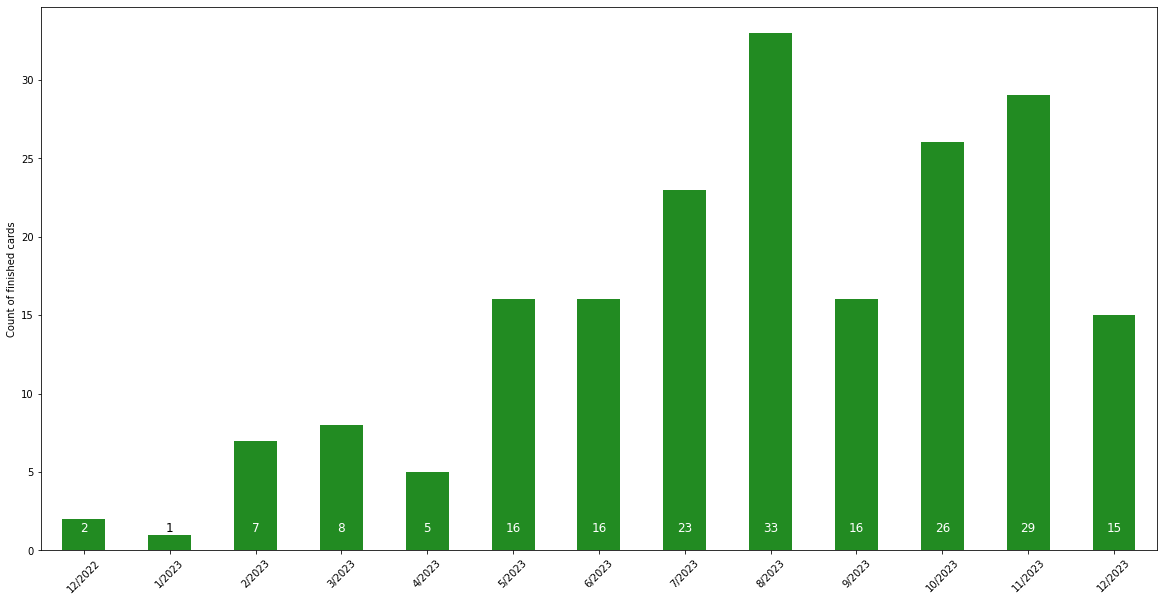

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(resample_time="1M", title="Count of finished cards", cards=finished_cards, get_date=get_last_move_date):
    data = dict((get_date(card), 1) for card in cards)
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Finished Cards'])
    df.index = pd.to_datetime(df.index)
    df.head()
    
    df = df.resample(resample_time).sum()
    ax = df.plot(figsize=(20,10), kind="bar", legend=False, color='forestgreen')
    plt.ylabel(title)
    
    for index, row in enumerate(df["Finished Cards"]):
        ax.text(index, 1, str(int(row)), ha='center', va='bottom', fontsize="large", color="black" if row < 2 else "white")
    
    plt.xticks(range(len(df.index)), [f"{d.month}/{d.year}" for d in df.index], rotation=45)
    plt.show()
    
plot(resample_time="1M")

# <span id="finished-cards-rolling">Rolling view: Finished cards in the last 30 days</span>

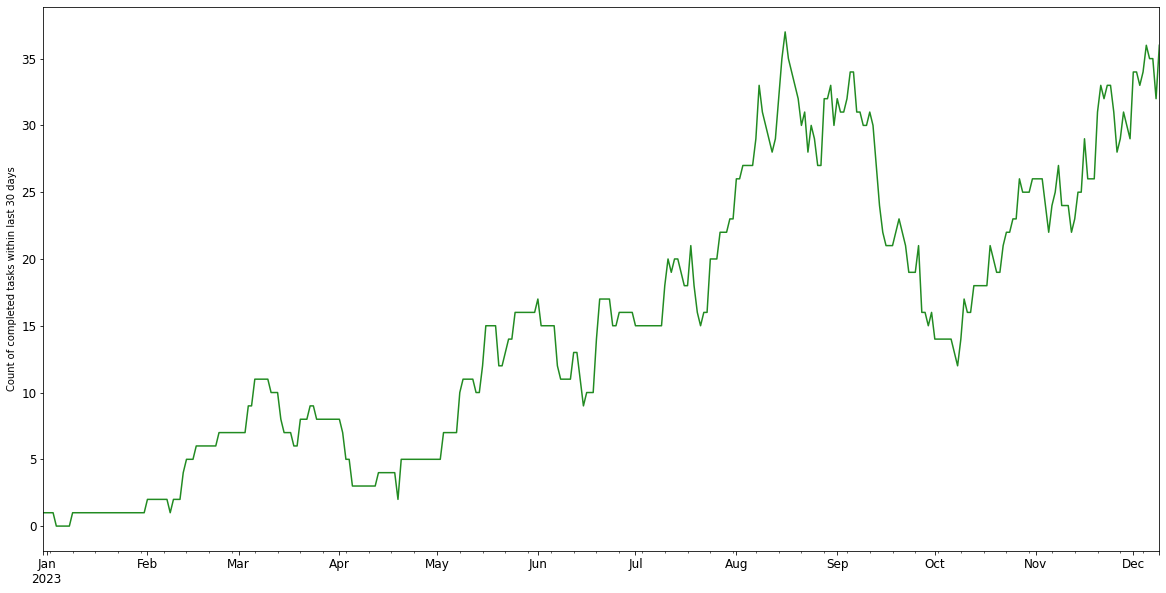

In [12]:
def plot_rolling(days=30, score_per_card= lambda x: 1, title="Count of completed tasks within last 30 days", cards=finished_cards):
    data = dict((get_last_move_date(card), score_per_card(card)) for card in cards)
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Finished Cards'])
    df.index = pd.to_datetime(df.index)
    df.head()
    
    df = df.resample("1D").sum().rolling(window=days, min_periods=days).sum()
    df = df[days:]
    df.plot(figsize=(20,10), legend=False, color="forestgreen", fontsize="large")
    plt.ylabel(title)
    plt.show()

plot_rolling()

# <span id="finished-feature-cards-per-month">Finished feature cards per month</span>

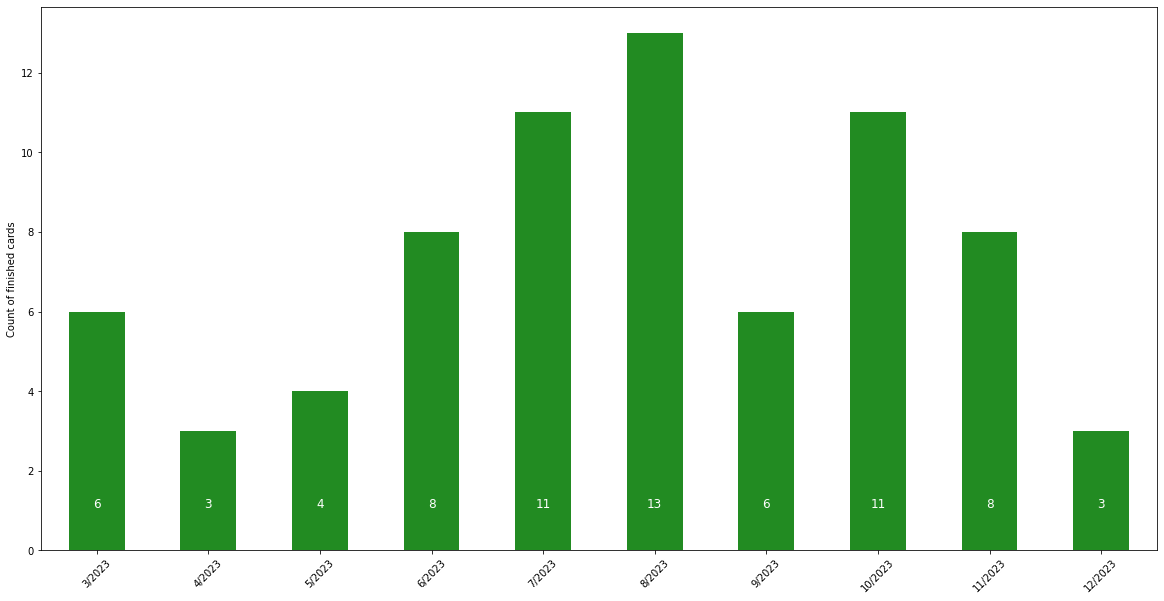

In [14]:
def is_feature(card):
    if any(label["name"] == "Dev" for label in card["labels"]):
        return False
    
    return any(label["name"] == "Feature" or label["name"] == "Mini-Feature" for label in card["labels"])

finished_features = [c for c in finished_cards if is_feature(c)]

plot(cards=finished_features)

# <span id="finished-cards-rolling-features">Rolling view: Finished feature cards in the last 30 days</span>

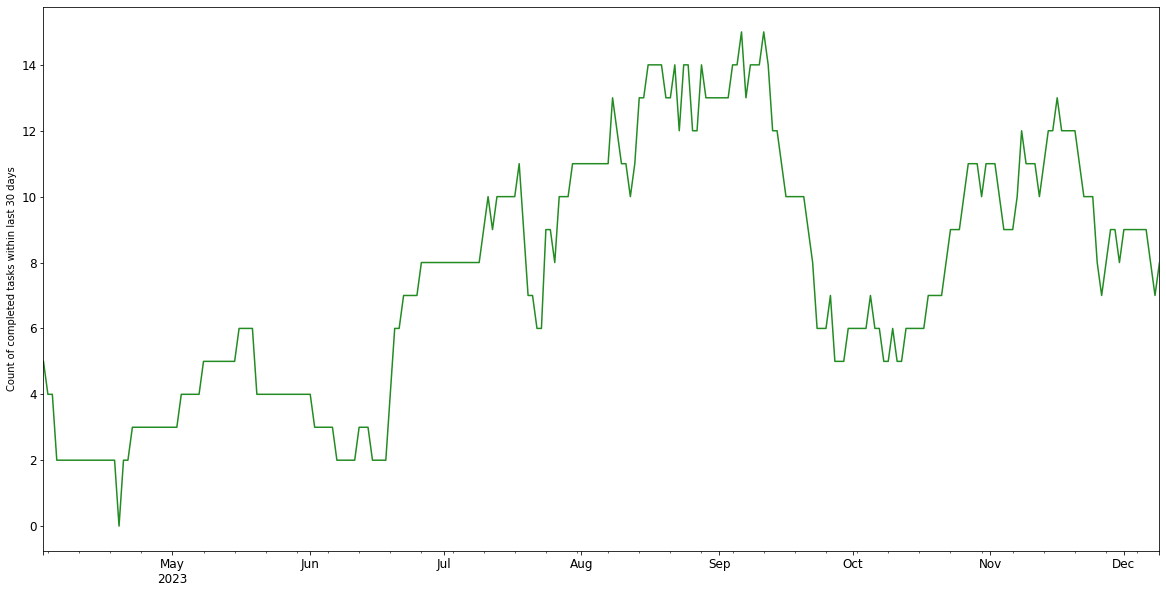

In [15]:
plot_rolling(cards=finished_features)

# <span id="regression-bugs">Number of regression bugs per month</span>

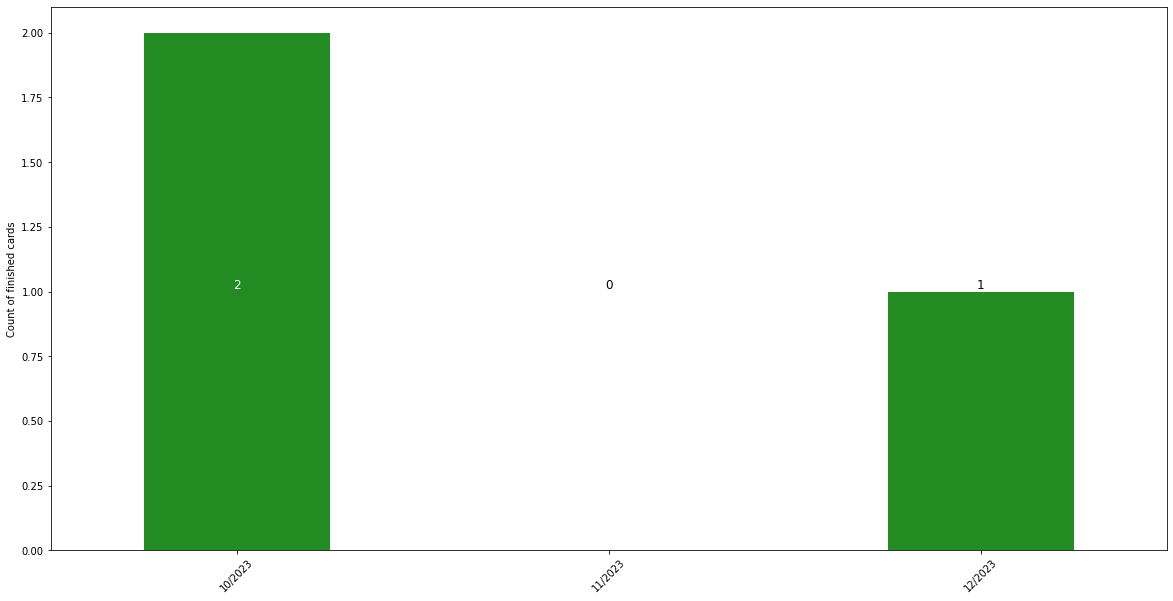

In [46]:
def is_regression_card(card):
    if not any(label["name"] == "Bug" for label in card["labels"]):
        return False

    return any('https://trello.com/c/' in attachment.get('url', '') for attachment in card["attachments"])

regression_bugs = [card for card in cards if is_regression_card(card)]

plot(cards=regression_bugs, get_date= lambda card: card["actions"][0]["date"])

# <span id="development-cards">Current cards in development</span>

In [16]:
from IPython.display import display, Markdown

for list_name in ["Entwicklung", "Feedback / Blocked", "Testen / PR Review"]:
    display(Markdown(f'## Aktuelle Karten in "{list_name}"'))
    current_cards = [card for card in cards if card["idList"] == list_name2list_id[list_name] and not card["closed"]]
    
    for c in current_cards:
        print_card(c, display_last_move_date=False)

## Aktuelle Karten in "Entwicklung"

## Aktuelle Karten in "Feedback / Blocked"

## Aktuelle Karten in "Testen / PR Review"

# <span id="changelog">Changelog</span>

In [17]:
finished_cards = [card for card in cards if card["idList"] == list_name2list_id["Veröffentlicht (kann genutzt werden)"]]
finished_cards = sorted(finished_cards, key=get_last_move_date, reverse=True)
grouped_cards = dict()

for card in finished_cards:
    finished_date = pd.to_datetime(get_last_move_date(card))
    
    key = f"{finished_date.month}/{finished_date.year}"
    
    if key not in grouped_cards:
        grouped_cards[key] = []
    
    grouped_cards[key].append(card)

for name, cards_of_this_month in grouped_cards.items():
    display(Markdown(f"## {name}"))
    
    for card in cards_of_this_month:
        print_card(card, display_time=False)

## 12/2023

## 11/2023

## 10/2023

## 9/2023

## 8/2023

## 7/2023

## 6/2023

## 5/2023

## 4/2023

## 3/2023

## 2/2023

## 1/2023

## 12/2022